In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import KernelDensity
from sklearn.covariance import EmpiricalCovariance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                            roc_curve, auc, precision_recall_curve, f1_score)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import (FastGradientMethod, ProjectedGradientDescent,
                                 CarliniL2Method, DeepFool)

warnings.filterwarnings('ignore')
print("✓ All libraries imported successfully.")

2025-11-02 09:11:16.622833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/reshma/Documents/Coding/capstone_project/attack/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/reshma/Documents/Coding/capstone_project/attack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/reshma/Documents/Coding/capstone_project/attack/lib/python3.9/site-packages/art/estimators/cert

✓ All libraries imported successfully.


In [ ]:
DATA_PATH = 'CIC-Darknet2020.csv'
MODEL_PATH = 'model-multi.h5'
SCALER_PATH = 'scaler-multi.pkl'
DEFENSE_MODEL_PATH = 'defense_models/combined_defense_autoencoder.h5'

TARGET_LABELS = ['Tor', 'Non-Tor', 'VPN', 'NonVPN']

DETECTION_CONFIG = {
    'reconstruction_threshold': 0.1,
    'squeezing_threshold': 0.3,
    'confidence_threshold': 0.9, 
    'entropy_threshold': 0.5,
    'margin_threshold': 0.2,
}

ATTACK_PARAMS = {
    'fgsm_eps': [0.05, 0.1, 0.15],
    'pgd_eps': [0.05, 0.1, 0.15],
    'pgd_iterations': 40,
    'cw_confidence': 0,
    'cw_iterations': 50,
}

FEATURE_CONSTRAINTS = {}
print("✓ Configuration set.")

✓ Configuration set.


In [ ]:
def load_data():
    print("Loading dataset...")
    df = pd.read_csv(DATA_PATH)
    
    df.columns = [*df.columns[:-2], 'Label', 'Label_Type']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df_multi = df[df['Label'].isin(TARGET_LABELS)].copy()
    
    non_feature_cols = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port',
                       'Protocol', 'Timestamp', 'Label', 'Label_Type']
    X = df_multi.drop(columns=non_feature_cols).apply(pd.to_numeric)
    y = df_multi['Label']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    n_classes = len(le.classes_)
    target_names = le.classes_
    y_ohe = to_categorical(y_encoded, num_classes=n_classes)
    
    X_train, X_test, y_train_ohe, y_test_ohe, y_train_enc, y_test_enc = train_test_split(
        X, y_ohe, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    scaler = joblib.load(SCALER_PATH)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    n_features = X_test_scaled.shape[1]
    X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], n_features, 1))
    X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], n_features, 1))
    
    print(f"✓ Data loaded: {len(X_test_cnn)} test samples, {n_features} features, {n_classes} classes")
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'X_train_cnn': X_train_cnn,
        'X_test_cnn': X_test_cnn,
        'y_train_ohe': y_train_ohe,
        'y_test_ohe': y_test_ohe,
        'y_train_enc': y_train_enc,
        'y_test_enc': y_test_enc,
        'target_names': target_names,
        'n_features': n_features,
        'n_classes': n_classes,
        'scaler': scaler,
        'feature_names': X.columns.tolist()
    }

data = load_data()

print("\nLoading models...")
classifier_model = load_model(MODEL_PATH)

try:
    autoencoder_model = load_model(DEFENSE_MODEL_PATH, compile=False)
    # Recompile with correct loss
    autoencoder_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    print("✓ Autoencoder loaded and recompiled.")
except Exception as e:
    print(f"⚠ Could not load autoencoder from {DEFENSE_MODEL_PATH}")
    print(f"Error: {e}")
    
    from tensorflow.keras import layers, models
    
    input_dim = data['n_features']
    encoding_dims = [64, 32, 16]
    
    input_layer = layers.Input(shape=(input_dim,))
    encoded = input_layer
    for dim in encoding_dims:
        encoded = layers.Dense(dim, activation='relu')(encoded)
        encoded = layers.BatchNormalization()(encoded)
        encoded = layers.Dropout(0.2)(encoded)
    
    bottleneck = layers.Dense(encoding_dims[-1] // 2, activation='relu', name='bottleneck')(encoded)
    
    decoded = bottleneck
    for dim in reversed(encoding_dims[:-1]):
        decoded = layers.Dense(dim, activation='relu')(decoded)
        decoded = layers.BatchNormalization()(decoded)
        decoded = layers.Dropout(0.2)(decoded)
    
    output_layer = layers.Dense(input_dim, activation='sigmoid')(decoded)
    
    autoencoder_model = models.Model(input_layer, output_layer)
    autoencoder_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                             loss='mse', metrics=['mae'])

print("✓ Classifier loaded.")

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
art_classifier = TensorFlowV2Classifier(
    model=classifier_model,
    loss_object=loss_object,
    input_shape=(data['n_features'], 1),
    nb_classes=data['n_classes'],
    channels_first=False
)
print("✓ ART classifier wrapper created.")


Loading dataset...
✓ Data loaded: 31714 test samples, 76 features, 4 classes

Loading models...


✓ Autoencoder loaded and recompiled.
✓ Classifier loaded.
✓ ART classifier wrapper created.


In [ ]:
class FeatureSqueezingDetector:
    def __init__(self, bit_depth=8):
        self.bit_depth = bit_depth
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def bit_depth_reduction(self, X):
        X_scaled = self.scaler.fit_transform(X)
        max_val = 2 ** self.bit_depth - 1
        X_quantized = np.round(X_scaled * max_val) / max_val
        return X_quantized
    
    def quantization(self, X, num_bins=256):
        X_scaled = self.scaler.fit_transform(X)
        X_quantized = np.floor(X_scaled * (num_bins - 1)) / (num_bins - 1)
        return X_quantized
    
    def apply_squeezing(self, X):
        X_squeezed = self.bit_depth_reduction(X)
        X_squeezed = self.quantization(X_squeezed)
        return X_squeezed

print("✓ Feature Squeezing Detector defined.")

✓ Feature Squeezing Detector defined.


In [ ]:
class DetectionSignals:    
    def __init__(self, autoencoder, classifier, feature_squeezer):
        self.autoencoder = autoencoder
        self.classifier = classifier
        self.feature_squeezer = feature_squeezer
        
        self.reconstruction_stats = {'mean': 0, 'std': 1}
        self.confidence_stats = {'mean': 0, 'std': 1}
        self.entropy_stats = {'mean': 0, 'std': 1}
        
        self.activation_layer = self._find_activation_layer()
        
    def _find_activation_layer(self):
        try:
            layer_names = [layer.name for layer in self.classifier.layers]
            
            conv_layers = [name for name in layer_names if 'conv' in name.lower()]
            if conv_layers:
                return conv_layers[-1]
            
            dense_layers = [name for name in layer_names if 'dense' in name.lower()]
            if dense_layers and len(dense_layers) > 1:
                return dense_layers[-2]
            
            return None
        except:
            return None
        
    def signal_1_reconstruction_error(self, X):
        X_reconstructed = self.autoencoder.predict(X, verbose=0)
        reconstruction_errors = np.mean(np.square(X - X_reconstructed), axis=1)
        return reconstruction_errors
    
    def signal_2_squeezing_consistency(self, X_cnn):
        pred_original = self.classifier.predict(X_cnn, verbose=0)
        
        X_2d = X_cnn.reshape(X_cnn.shape[0], -1)
        X_squeezed = self.feature_squeezer.apply_squeezing(X_2d)
        X_squeezed_cnn = X_squeezed.reshape(X_cnn.shape).astype(np.float32)
        pred_squeezed = self.classifier.predict(X_squeezed_cnn, verbose=0)
        
        kl_divs = np.sum(pred_original * np.log((pred_original + 1e-10) / (pred_squeezed + 1e-10)), axis=1)
        
        class_changes = (np.argmax(pred_original, axis=1) != np.argmax(pred_squeezed, axis=1)).astype(float)
        
        return kl_divs, class_changes
    
    def signal_3_prediction_confidence(self, X_cnn):
        predictions = self.classifier.predict(X_cnn, verbose=0)
        max_confidence = np.max(predictions, axis=1)
        
        entropy = -np.sum(predictions * np.log(predictions + 1e-10), axis=1)
        
        top2 = np.partition(predictions, -2, axis=1)[:, -2:]
        margin = top2[:, 1] - top2[:, 0]
        
        return max_confidence, entropy, margin
    
    def signal_4_physical_plausibility(self, X, feature_constraints):
        violations = np.zeros(len(X))
        
        for i, (min_val, max_val, mean_val, std_val) in enumerate(feature_constraints):
            out_of_range = (X[:, i] < min_val) | (X[:, i] > max_val)
            z_scores = np.abs((X[:, i] - mean_val) / (std_val + 1e-10))
            outliers = z_scores > 3
            
            violations += (out_of_range | outliers).astype(float)
    
        violations = violations / len(feature_constraints)
        
        return violations
    
    def signal_5_layer_activation_stats(self, X_cnn):        
        if self.activation_layer is None:
            predictions = self.classifier.predict(X_cnn, verbose=0)
            entropy = -np.sum(predictions * np.log(predictions + 1e-10), axis=1)
            return entropy
        
        try:
            layer_output = self.classifier.get_layer(self.activation_layer).output
            intermediate_model = Model(inputs=self.classifier.input, outputs=layer_output)
            
            activations = intermediate_model.predict(X_cnn, verbose=0)
            activations_flat = activations.reshape(activations.shape[0], -1)
            lid_scores = np.var(activations_flat, axis=1)
            
            return lid_scores
            
        except Exception as e:
            print(f"⚠ Warning: Could not extract activations from '{self.activation_layer}': {e}")
            print("  Using prediction entropy as fallback...")
            
            predictions = self.classifier.predict(X_cnn, verbose=0)
            entropy = -np.sum(predictions * np.log(predictions + 1e-10), axis=1)
            
            return entropy
    
    def extract_all_signals(self, X_2d, X_cnn, feature_constraints):
        signals = {}
        
        signals['reconstruction_error'] = self.signal_1_reconstruction_error(X_2d)
        
        kl_divs, class_changes = self.signal_2_squeezing_consistency(X_cnn)
        signals['kl_divergence'] = kl_divs
        signals['class_change'] = class_changes
        
        max_conf, entropy, margin = self.signal_3_prediction_confidence(X_cnn)
        signals['max_confidence'] = max_conf
        signals['entropy'] = entropy
        signals['margin'] = margin
        
        signals['plausibility_violations'] = self.signal_4_physical_plausibility(
            X_2d, feature_constraints
        )
        signals['lid_scores'] = self.signal_5_layer_activation_stats(X_cnn)
        
        return signals

print("✓ Detection Signals class defined.")

print("\n--- Checking classifier architecture ---")
print("Available layers in classifier:")
for idx, layer in enumerate(classifier_model.layers):
    print(f"  {idx}: {layer.name} ({layer.__class__.__name__})")


✓ Detection Signals class defined.

--- Checking classifier architecture ---
Available layers in classifier:
  0: conv1d (Conv1D)
  1: max_pooling1d (MaxPooling1D)
  2: conv1d_1 (Conv1D)
  3: max_pooling1d_1 (MaxPooling1D)
  4: conv1d_2 (Conv1D)
  5: global_average_pooling1d (GlobalAveragePooling1D)
  6: dropout (Dropout)
  7: dense (Dense)
  8: dense_1 (Dense)


In [ ]:
def calculate_feature_constraints(X_train):
    constraints = []
    for i in range(X_train.shape[1]):
        min_val = np.min(X_train[:, i])
        max_val = np.max(X_train[:, i])
        mean_val = np.mean(X_train[:, i])
        std_val = np.std(X_train[:, i])
        constraints.append((min_val, max_val, mean_val, std_val))
    return constraints

def calibrate_detectors(signals_extractor, X_train, X_train_cnn, feature_constraints):
    print("\n" + "="*70)
    print("CALIBRATING DETECTION THRESHOLDS ON CLEAN DATA")
    print("="*70)
    
    subset_size = min(5000, len(X_train))
    X_subset = X_train[:subset_size]
    X_subset_cnn = X_train_cnn[:subset_size]
    
    print(f"\nExtracting signals from {subset_size} clean samples...")
    clean_signals = signals_extractor.extract_all_signals(
        X_subset, X_subset_cnn, feature_constraints
    )
    
    thresholds = {}
    
    for signal_name, values in clean_signals.items():
        percentile_95 = np.percentile(values, 95)
        percentile_99 = np.percentile(values, 99)
        mean_val = np.mean(values)
        std_val = np.std(values)
        
        thresholds[signal_name] = {
            'mean': mean_val,
            'std': std_val,
            'p95': percentile_95,
            'p99': percentile_99
        }
        
        print(f"\n{signal_name}:")
        print(f"  Mean: {mean_val:.6f}, Std: {std_val:.6f}")
        print(f"  95th percentile: {percentile_95:.6f}")
        print(f"  99th percentile: {percentile_99:.6f}")
    
    print("\n✓ Calibration complete!")
    return thresholds, clean_signals

print("\nCalculating feature constraints...")
feature_constraints = calculate_feature_constraints(data['X_train'])
print(f"✓ Calculated constraints for {len(feature_constraints)} features")

feature_squeezer = FeatureSqueezingDetector(bit_depth=8)
signals_extractor = DetectionSignals(
    autoencoder_model,
    classifier_model,
    feature_squeezer
)

thresholds, clean_signals = calibrate_detectors(
    signals_extractor,
    data['X_train'],
    data['X_train_cnn'],
    feature_constraints
)

joblib.dump(thresholds, 'detection_thresholds.pkl')
joblib.dump(feature_constraints, 'feature_constraints.pkl')
print("\n✓ Thresholds and constraints saved.")


Calculating feature constraints...
✓ Calculated constraints for 76 features

CALIBRATING DETECTION THRESHOLDS ON CLEAN DATA

Extracting signals from 5000 clean samples...
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...

reconstruction_error:
  Mean: 1.122099, Std: 34.271006
  95th percentile: 1.307704
  99th percentile: 3.559373

kl_divergence:
  Mean: 6.963544, Std: 10.270988
  95th percentile: 22.984386
  99th percentile: 23.014880

class_change:
  Mean: 0.303800, Std: 0.459897
  95th percentile: 1.000000
  99th percentile: 1.000000

max_confidence:
  Mean: 0.948004, Std: 0.112007
  95th percentile: 0.999988
  99th percentile: 0.999999

entropy:
  Mean: 0.142416, Std: 0.233110
  95th percentile: 0.719844
  99th percentile: 0.961411

margin:
  Mean: 0.903581, Std: 0.208202
  95th percentile: 0.999978
  99th percentile: 0.999999

plausibility_violations:
  Mean

In [ ]:
class AdversarialDetector:    
    def __init__(self, signals_extractor, thresholds, feature_constraints):
        self.signals_extractor = signals_extractor
        self.thresholds = thresholds
        self.feature_constraints = feature_constraints
        
        self.weights = {
            'reconstruction_error': 1.5,
            'kl_divergence': 1.2,
            'class_change': 2.0,
            'max_confidence': 0.8,
            'entropy': 1.0,
            'margin': 1.0,
            'plausibility_violations': 1.8,
            'lid_scores': 1.0
        }
    
    def detect_single_signal(self, signal_values, signal_name, threshold_type='p95'):
        threshold = self.thresholds[signal_name][threshold_type]
        
        if signal_name in ['reconstruction_error', 'kl_divergence', 'plausibility_violations', 'lid_scores']:
            detections = signal_values > threshold
        elif signal_name == 'entropy':
            detections = signal_values < threshold
        elif signal_name == 'max_confidence':
            detections = signal_values > threshold
        elif signal_name == 'margin':
            detections = signal_values < threshold
        elif signal_name == 'class_change':
            detections = signal_values > 0.5
        else:
            detections = signal_values > threshold
        
        return detections.astype(float)
    
    def detect_ensemble(self, X_2d, X_cnn, threshold_type='p95'):
        signals = self.signals_extractor.extract_all_signals(
            X_2d, X_cnn, self.feature_constraints
        )

        detection_scores = np.zeros(len(X_2d))
        individual_detections = {}
        
        for signal_name, signal_values in signals.items():
            detections = self.detect_single_signal(signal_values, signal_name, threshold_type)
            weight = self.weights.get(signal_name, 1.0)
            detection_scores += detections * weight
            individual_detections[signal_name] = detections
        
        max_possible_score = sum(self.weights.values())
        detection_scores = detection_scores / max_possible_score
        
        return detection_scores, signals, individual_detections
    
    def detect_with_threshold(self, X_2d, X_cnn, detection_threshold=0.5, threshold_type='p95'):
        detection_scores, signals, individual_detections = self.detect_ensemble(
            X_2d, X_cnn, threshold_type
        )
        
        binary_detections = (detection_scores >= detection_threshold).astype(int)
        
        return binary_detections, detection_scores, signals, individual_detections
    
    def detect_cascaded(self, X_2d, X_cnn):
        n_samples = len(X_2d)
        
        plausibility = self.signals_extractor.signal_4_physical_plausibility(
            X_2d, self.feature_constraints
        )
        
        fast_detections = plausibility > self.thresholds['plausibility_violations']['p95']
        
        suspicious_indices = np.where(fast_detections)[0]
        medium_detections = fast_detections.copy()
        
        if len(suspicious_indices) > 0:
            X_suspicious = X_2d[suspicious_indices]
            recon_errors = self.signals_extractor.signal_1_reconstruction_error(X_suspicious)
            threshold = self.thresholds['reconstruction_error']['p95']
            medium_detections[suspicious_indices] = recon_errors > threshold
        
        deep_suspicious_indices = np.where(medium_detections)[0]
        final_detections = medium_detections.copy()
        final_scores = np.zeros(n_samples)
        
        if len(deep_suspicious_indices) > 0:
            X_deep = X_2d[deep_suspicious_indices]
            X_deep_cnn = X_cnn[deep_suspicious_indices]
            
            scores, _, _ = self.detect_ensemble(X_deep, X_deep_cnn)
            final_scores[deep_suspicious_indices] = scores
            final_detections[deep_suspicious_indices] = scores > 0.5
        
        return final_detections, final_scores

print("✓ Adversarial Detector class defined.")

detector = AdversarialDetector(signals_extractor, thresholds, feature_constraints)
print("✓ Detector initialized.")

✓ Adversarial Detector class defined.
✓ Detector initialized.


In [ ]:
def generate_attack_dataset(art_classifier, X_test_cnn, y_test_ohe, attack_params):
    print("\n" + "="*70)
    print("GENERATING ADVERSARIAL ATTACK DATASET")
    print("="*70)
    
    subset_size = min(5000, len(X_test_cnn))
    X_subset = X_test_cnn[:subset_size].astype(np.float32)
    y_subset = y_test_ohe[:subset_size]
    
    attacks = {}
    
    for eps in attack_params['fgsm_eps']:
        print(f"\nGenerating FGSM (eps={eps})...")
        fgsm = FastGradientMethod(art_classifier, eps=eps, batch_size=64)
        X_adv = fgsm.generate(x=X_subset, y=y_subset)
        attacks[f'fgsm_{eps}'] = X_adv
        print(f"✓ Generated {len(X_adv)} samples")
    
    for eps in attack_params['pgd_eps']:
        print(f"\nGenerating PGD (eps={eps}, iter={attack_params['pgd_iterations']})...")
        pgd = ProjectedGradientDescent(
            art_classifier, eps=eps, eps_step=eps/10,
            max_iter=attack_params['pgd_iterations'], batch_size=64, verbose=False
        )
        X_adv = pgd.generate(x=X_subset, y=y_subset)
        attacks[f'pgd_{eps}'] = X_adv
        print(f"✓ Generated {len(X_adv)} samples")
    
    cw_subset_size = min(500, subset_size)
    print(f"\nGenerating C&W attack on {cw_subset_size} samples (this may take a while)...")
    try:
        cw = CarliniL2Method(
            art_classifier,
            confidence=attack_params['cw_confidence'],
            max_iter=attack_params['cw_iterations'],
            batch_size=16
        )
        X_adv = cw.generate(x=X_subset[:cw_subset_size], y=y_subset[:cw_subset_size])
        attacks['cw'] = X_adv
        print(f"✓ Generated {len(X_adv)} samples")
    except Exception as e:
        print(f"⚠ C&W attack failed: {e}")
        attacks['cw'] = None
    
    print("\n✓ Attack dataset generation complete!")
    return attacks, X_subset

attacks, X_clean_subset = generate_attack_dataset(
    art_classifier,
    data['X_test_cnn'],
    data['y_test_ohe'],
    ATTACK_PARAMS
)

print(f"\n✓ Generated {len(attacks)} attack types")


GENERATING ADVERSARIAL ATTACK DATASET

Generating FGSM (eps=0.05)...
✓ Generated 5000 samples

Generating FGSM (eps=0.1)...
✓ Generated 5000 samples

Generating FGSM (eps=0.15)...
✓ Generated 5000 samples

Generating PGD (eps=0.05, iter=40)...


2025-11-02 09:17:48.009106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✓ Generated 5000 samples

Generating PGD (eps=0.1, iter=40)...


2025-11-02 09:20:53.586528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✓ Generated 5000 samples

Generating PGD (eps=0.15, iter=40)...


2025-11-02 09:23:40.980079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✓ Generated 5000 samples

Generating C&W attack on 500 samples (this may take a while)...


C&W L_2:   0%|          | 0/32 [00:00<?, ?it/s]

C&W L_2: 100%|██████████| 32/32 [54:35<00:00, 102.37s/it]

✓ Generated 500 samples

✓ Attack dataset generation complete!

✓ Generated 7 attack types


In [ ]:
def evaluate_detector(detector, X_clean, attacks, threshold_type='p95'):
    print("\n" + "="*70)
    print(f"EVALUATING DETECTION PERFORMANCE (threshold={threshold_type})")
    print("="*70)
    
    results = {}
    
    print("\nEvaluating on clean data...")
    X_clean_2d = X_clean.reshape(X_clean.shape[0], -1)
    
    binary_det, scores, _, _ = detector.detect_with_threshold(
        X_clean_2d, X_clean, detection_threshold=0.5, threshold_type=threshold_type
    )
    
    fpr = binary_det.mean()
    results['clean'] = {
        'fpr': fpr,
        'mean_score': scores.mean(),
        'std_score': scores.std()
    }
    
    print(f"  False Positive Rate: {fpr*100:.2f}%")
    print(f"  Mean Detection Score: {scores.mean():.4f} ± {scores.std():.4f}")
    
    for attack_name, X_adv in attacks.items():
        if X_adv is None:
            continue
            
        print(f"\nEvaluating on {attack_name}...")
        X_adv_2d = X_adv.reshape(X_adv.shape[0], -1)
        
        binary_det, scores, _, _ = detector.detect_with_threshold(
            X_adv_2d, X_adv, detection_threshold=0.5, threshold_type=threshold_type
        )
        
        tpr = binary_det.mean()
        results[attack_name] = {
            'tpr': tpr,
            'mean_score': scores.mean(),
            'std_score': scores.std()
        }
        
        print(f"  Detection Rate (TPR): {tpr*100:.2f}%")
        print(f"  Mean Detection Score: {scores.mean():.4f} ± {scores.std():.4f}")
    
    return results

detection_results_p95 = evaluate_detector(detector, X_clean_subset, attacks, threshold_type='p95')
detection_results_p99 = evaluate_detector(detector, X_clean_subset, attacks, threshold_type='p99')


EVALUATING DETECTION PERFORMANCE (threshold=p95)

Evaluating on clean data...
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...
  False Positive Rate: 8.28%
  Mean Detection Score: 0.2739 ± 0.1213

Evaluating on fgsm_0.05...
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...
  Detection Rate (TPR): 68.50%
  Mean Detection Score: 0.5046 ± 0.0954

Evaluating on fgsm_0.1...
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...
  Detection Rate (TPR): 93.22%
  Mean Detection Score: 0.5548 ± 0.0580

Evaluating on fgsm_0.15...
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and 


ANALYZING INDIVIDUAL SIGNAL CONTRIBUTIONS

--- FGSM_0.05 ---
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...
  reconstruction_error          :   5.24% detection
  kl_divergence                 :   0.16% detection
  class_change                  :  65.88% detection
  max_confidence                :   0.38% detection
  entropy                       :  53.84% detection
  margin                        :  99.62% detection
  plausibility_violations       : 100.00% detection
  lid_scores                    :  46.16% detection

--- FGSM_0.1 ---
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...
  reconstruction_error          :   5.28% detection
  kl_divergence                 :   0.12% detection
  class_change                  :  91.72% detection


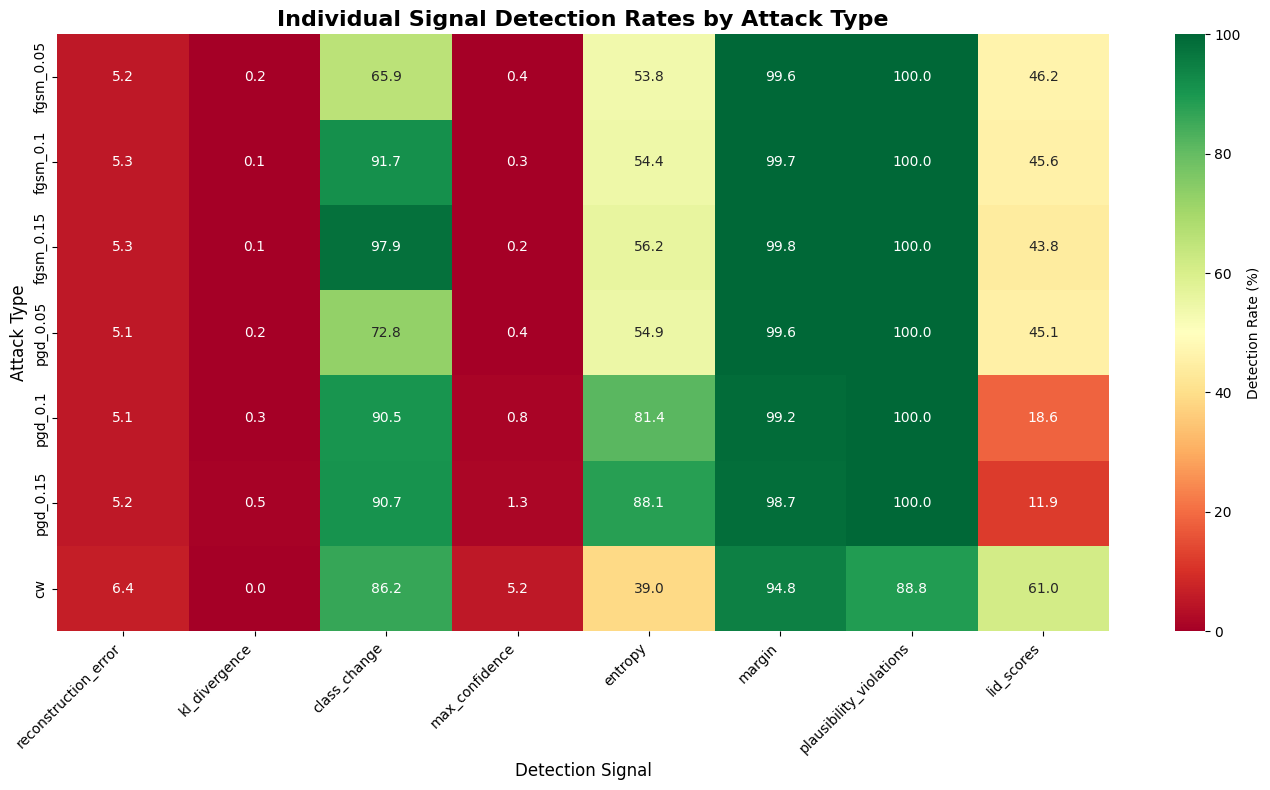


✓ Signal analysis complete!


In [ ]:
def analyze_individual_signals(detector, X_clean, attacks, threshold_type='p95'):
    print("\n" + "="*70)
    print("ANALYZING INDIVIDUAL SIGNAL CONTRIBUTIONS")
    print("="*70)
    
    X_clean_2d = X_clean.reshape(X_clean.shape[0], -1)
    
    signal_results = {}
    
    for attack_name, X_adv in attacks.items():
        if X_adv is None:
            continue
        
        print(f"\n--- {attack_name.upper()} ---")
        X_adv_2d = X_adv.reshape(X_adv.shape[0], -1)
        
        _, _, _, individual_detections = detector.detect_with_threshold(
            X_adv_2d, X_adv, threshold_type=threshold_type
        )
        
        signal_results[attack_name] = {}
        
        for signal_name, detections in individual_detections.items():
            tpr = detections.mean()
            signal_results[attack_name][signal_name] = tpr
            print(f"  {signal_name:30s}: {tpr*100:6.2f}% detection")
    
    df_signals = pd.DataFrame(signal_results).T
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(df_signals * 100, annot=True, fmt='.1f', cmap='RdYlGn',
               cbar_kws={'label': 'Detection Rate (%)'}, vmin=0, vmax=100)
    plt.title('Individual Signal Detection Rates by Attack Type',
             fontsize=16, fontweight='bold')
    plt.xlabel('Detection Signal', fontsize=12)
    plt.ylabel('Attack Type', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('signal_contributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Signal analysis complete!")
    return signal_results

signal_analysis = analyze_individual_signals(detector, X_clean_subset, attacks, threshold_type='p95')

In [ ]:
def test_unknown_attack_generalization(detector, X_clean, attacks, known_attacks, unknown_attack):
    print("\n" + "="*70)
    print("TESTING GENERALIZATION TO UNKNOWN ATTACKS")
    print("="*70)
    
    X_clean_2d = X_clean.reshape(X_clean.shape[0], -1)
    
    print(f"\nDetector was calibrated on: {', '.join(known_attacks)}")
    print(f"Testing generalization to: {unknown_attack}")
    
    if attacks[unknown_attack] is None:
        print(f"\n⚠ {unknown_attack} attack not available. Skipping.")
        return None
    
    X_unknown = attacks[unknown_attack]
    X_unknown_2d = X_unknown.reshape(X_unknown.shape[0], -1)
    
    binary_det, scores, signals, individual_det = detector.detect_with_threshold(
        X_unknown_2d, X_unknown, threshold_type='p95'
    )
    
    tpr = binary_det.mean()
    
    print(f"\n{unknown_attack.upper()} Detection Results:")
    print(f"  Detection Rate: {tpr*100:.2f}%")
    print(f"  Mean Score: {scores.mean():.4f} ± {scores.std():.4f}")
    
    print(f"\nPer-signal detection rates:")
    for signal_name, detections in individual_det.items():
        print(f"  {signal_name:30s}: {detections.mean()*100:6.2f}%")
    
    print(f"\nComparison with known attacks:")
    for known_attack in known_attacks:
        if attacks[known_attack] is not None:
            X_known = attacks[known_attack]
            X_known_2d = X_known.reshape(X_known.shape[0], -1)
            _, known_scores, _, _ = detector.detect_with_threshold(X_known_2d, X_known, threshold_type='p95')
            print(f"  {known_attack:15s}: {known_scores.mean()*100:6.2f}% avg score")
    
    print(f"  {unknown_attack:15s}: {scores.mean()*100:6.2f}% avg score")
    
    return tpr, scores

if attacks.get('cw') is not None:
    cw_results = test_unknown_attack_generalization(
        detector, X_clean_subset, attacks,
        known_attacks=['fgsm_0.1', 'pgd_0.1'],
        unknown_attack='cw'
    )


TESTING GENERALIZATION TO UNKNOWN ATTACKS

Detector was calibrated on: fgsm_0.1, pgd_0.1
Testing generalization to: cw
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...

CW Detection Results:
  Detection Rate: 82.40%
  Mean Score: 0.5250 ± 0.1122

Per-signal detection rates:
  reconstruction_error          :   6.40%
  kl_divergence                 :   0.00%
  class_change                  :  86.20%
  max_confidence                :   5.20%
  entropy                       :  39.00%
  margin                        :  94.80%
  plausibility_violations       :  88.80%
  lid_scores                    :  61.00%

Comparison with known attacks:
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...
  fgsm_0.1       :  55.48% avg score
⚠ Warning: Could not

In [ ]:
def detection_confusion_analysis(detector, X_clean, attacks, classifier_model, 
                                y_test_enc, threshold_type='p95'):
    print("\n" + "="*70)
    print("DETECTION PERFORMANCE BY TRAFFIC CLASS")
    print("="*70)
    
    X_clean_2d = X_clean.reshape(X_clean.shape[0], -1)
    y_true = y_test_enc[:len(X_clean)]
    
    y_pred = classifier_model.predict(X_clean, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    for attack_name, X_adv in attacks.items():
        if X_adv is None:
            continue
        
        print(f"\n--- {attack_name.upper()} ---")
        
        actual_size = len(X_adv)
        y_true_subset = y_true[:actual_size]
        y_pred_classes_subset = y_pred_classes[:actual_size]
        
        X_adv_2d = X_adv.reshape(X_adv.shape[0], -1)
        
        y_pred_adv = classifier_model.predict(X_adv, verbose=0)
        y_pred_adv_classes = np.argmax(y_pred_adv, axis=1)
        
        binary_det, scores, _, _ = detector.detect_with_threshold(
            X_adv_2d, X_adv, threshold_type=threshold_type
        )

        print("\nDetection rate by true class:")
        for class_idx in range(data['n_classes']):
            class_mask = y_true_subset == class_idx
            if class_mask.sum() > 0:
                class_det_rate = binary_det[class_mask].mean()
                class_count = class_mask.sum()
                print(f"  {data['target_names'][class_idx]:15s}: {class_det_rate*100:6.2f}% ({class_count} samples)")
        
        successful_attacks = y_pred_classes_subset != y_pred_adv_classes
        failed_attacks = y_pred_classes_subset == y_pred_adv_classes
        
        if successful_attacks.sum() > 0:
            success_det_rate = binary_det[successful_attacks].mean()
            print(f"\nDetection on successful attacks: {success_det_rate*100:.2f}% ({successful_attacks.sum()} samples)")
        
        if failed_attacks.sum() > 0:
            failed_det_rate = binary_det[failed_attacks].mean()
            print(f"Detection on failed attacks: {failed_det_rate*100:.2f}% ({failed_attacks.sum()} samples)")

detection_confusion_analysis(
    detector, X_clean_subset, attacks,
    classifier_model, data['y_test_enc'],
    threshold_type='p95'
)


DETECTION PERFORMANCE BY TRAFFIC CLASS

--- FGSM_0.05 ---
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...

Detection rate by true class:
  Non-Tor        :  57.16% (3511 samples)
  NonVPN         :  93.29% (700 samples)
  Tor            : 100.00% (42 samples)
  VPN            :  96.79% (747 samples)

Detection on successful attacks: 96.90% (2127 samples)
Detection on failed attacks: 47.48% (2873 samples)

--- FGSM_0.1 ---
⚠ Warning: Could not extract activations from 'conv1d_2': The layer sequential has never been called and thus has no defined input.
  Using prediction entropy as fallback...

Detection rate by true class:
  Non-Tor        :  92.99% (3511 samples)
  NonVPN         :  90.86% (700 samples)
  Tor            : 100.00% (42 samples)
  VPN            :  96.12% (747 samples)

Detection on successful attacks: 97.57% (3619 samples)
Detection on failed at


COMPREHENSIVE DETECTION RESULTS SUMMARY

   Attack  TPR (p95)  TPR (p99)  Mean Score (p95)             Best Signal  Best Signal TPR  Cascaded TPR  Time (ms)
FGSM_0.05      68.50      66.44          0.504598 plausibility_violations            100.0          5.20   0.337287
 FGSM_0.1      93.22      91.94          0.554808 plausibility_violations            100.0          5.28   0.200930
FGSM_0.15      98.24      98.02          0.566860 plausibility_violations            100.0          5.30   0.200959
 PGD_0.05      75.10      73.28          0.517922 plausibility_violations            100.0          5.10   0.209757
  PGD_0.1      91.18      90.70          0.552297 plausibility_violations            100.0          5.10   0.258689
 PGD_0.15      90.96      90.80          0.553016 plausibility_violations            100.0          5.22   0.231389
       CW      82.40      81.20          0.525049                  margin             94.8          5.60   1.467550

✓ Summary saved to 'detection

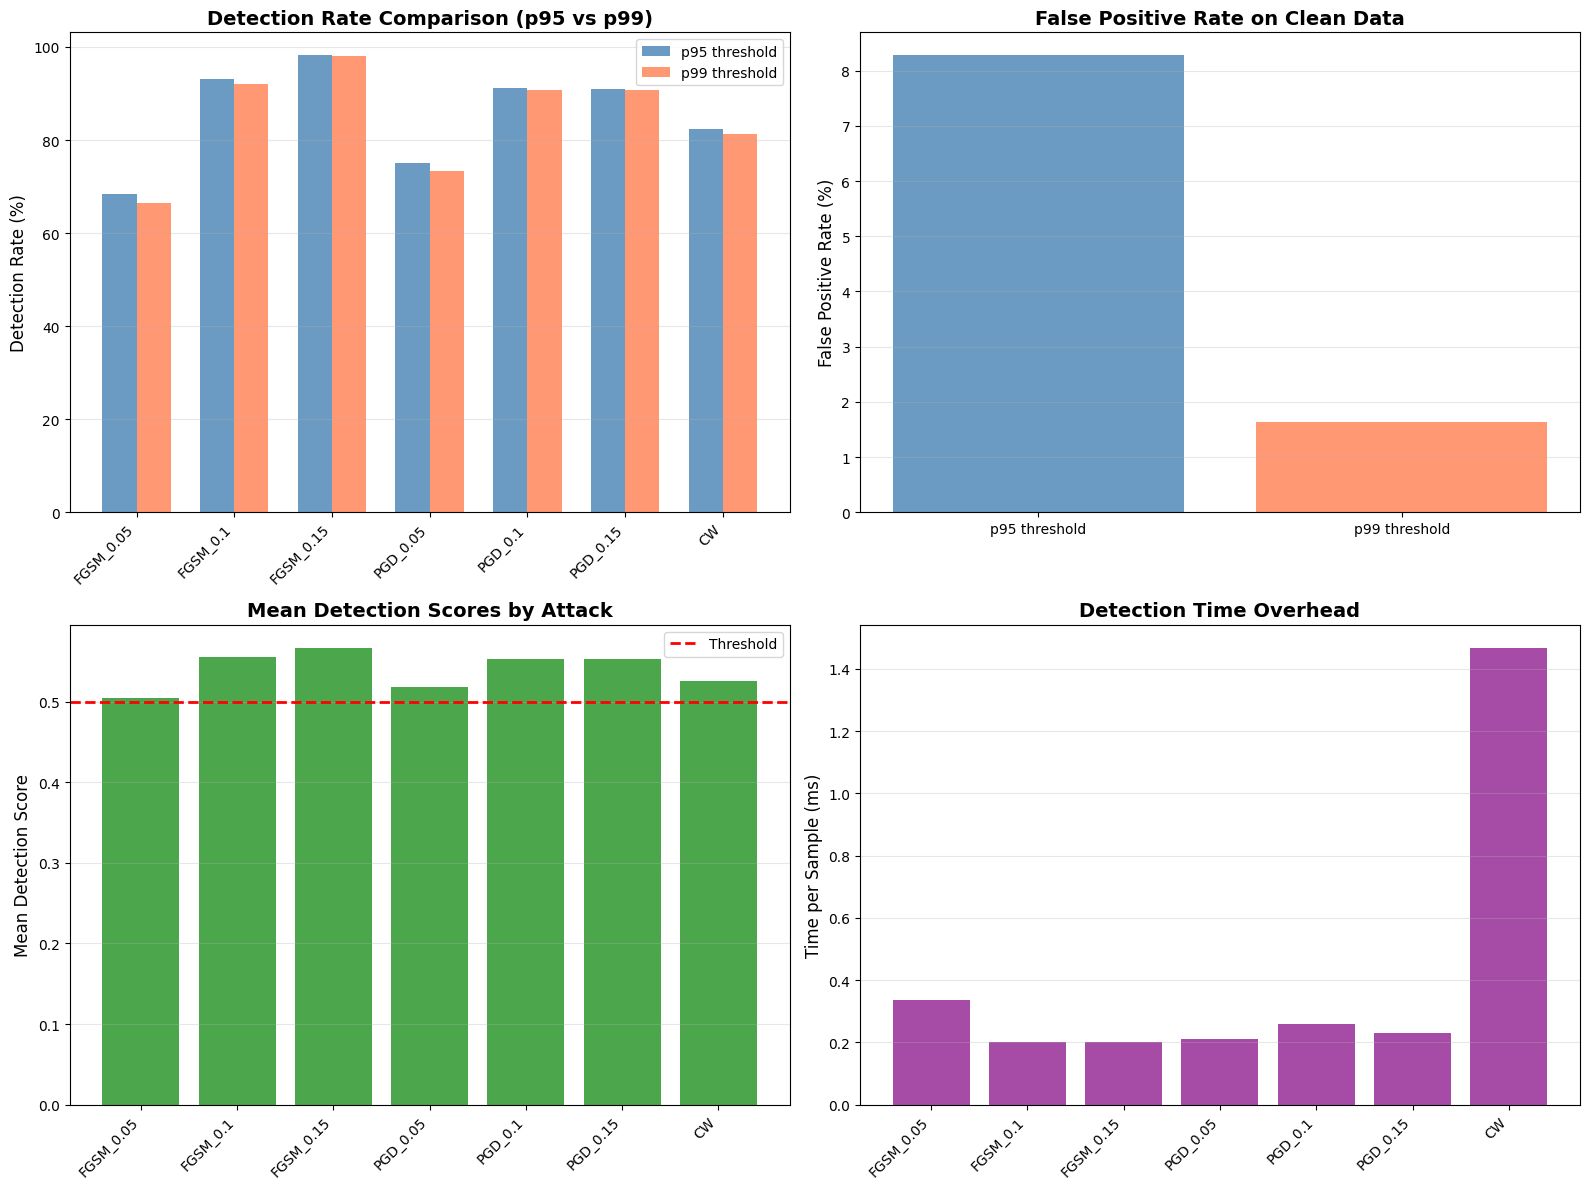

In [ ]:
def create_detection_summary(detection_results_p95, detection_results_p99, 
                            signal_analysis, cascaded_results):
    print("\n" + "="*70)
    print("COMPREHENSIVE DETECTION RESULTS SUMMARY")
    print("="*70)
    
    # Summary table
    summary_data = []
    
    for attack_name in detection_results_p95.keys():
        if attack_name == 'clean':
            continue
        
        row = {
            'Attack': attack_name.upper(),
            'TPR (p95)': detection_results_p95[attack_name]['tpr'] * 100,
            'TPR (p99)': detection_results_p99[attack_name]['tpr'] * 100,
            'Mean Score (p95)': detection_results_p95[attack_name]['mean_score'],
        }
        
        # Add best signal
        if attack_name in signal_analysis:
            best_signal = max(signal_analysis[attack_name].items(), key=lambda x: x[1])
            row['Best Signal'] = best_signal[0]
            row['Best Signal TPR'] = best_signal[1] * 100
        
        # Add cascaded results if available
        if attack_name in cascaded_results:
            row['Cascaded TPR'] = cascaded_results[attack_name]['tpr'] * 100
            row['Time (ms)'] = cascaded_results[attack_name]['time_per_sample']
        
        summary_data.append(row)
    
    df_summary = pd.DataFrame(summary_data)
    
    print("\n" + df_summary.to_string(index=False))
    
    # Save to CSV
    df_summary.to_csv('detection_results_summary.csv', index=False)
    print("\n✓ Summary saved to 'detection_results_summary.csv'")
    
    # Plot comprehensive comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # TPR comparison (p95 vs p99)
    attacks_list = df_summary['Attack'].tolist()
    x = np.arange(len(attacks_list))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, df_summary['TPR (p95)'], width, 
                   label='p95 threshold', alpha=0.8, color='steelblue')
    axes[0, 0].bar(x + width/2, df_summary['TPR (p99)'], width,
                   label='p99 threshold', alpha=0.8, color='coral')
    axes[0, 0].set_ylabel('Detection Rate (%)', fontsize=12)
    axes[0, 0].set_title('Detection Rate Comparison (p95 vs p99)',
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(attacks_list, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # FPR comparison
    fpr_p95 = detection_results_p95['clean']['fpr'] * 100
    fpr_p99 = detection_results_p99['clean']['fpr'] * 100
    
    axes[0, 1].bar(['p95 threshold', 'p99 threshold'], [fpr_p95, fpr_p99],
                   color=['steelblue', 'coral'], alpha=0.8)
    axes[0, 1].set_ylabel('False Positive Rate (%)', fontsize=12)
    axes[0, 1].set_title('False Positive Rate on Clean Data',
                        fontsize=14, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Detection scores by attack
    axes[1, 0].bar(attacks_list, df_summary['Mean Score (p95)'],
                   color='green', alpha=0.7)
    axes[1, 0].axhline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[1, 0].set_ylabel('Mean Detection Score', fontsize=12)
    axes[1, 0].set_title('Mean Detection Scores by Attack',
                        fontsize=14, fontweight='bold')
    axes[1, 0].set_xticklabels(attacks_list, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Time per sample (if available)
    if 'Time (ms)' in df_summary.columns:
        axes[1, 1].bar(attacks_list, df_summary['Time (ms)'],
                       color='purple', alpha=0.7)
        axes[1, 1].set_ylabel('Time per Sample (ms)', fontsize=12)
        axes[1, 1].set_title('Detection Time Overhead',
                            fontsize=14, fontweight='bold')
        axes[1, 1].set_xticklabels(attacks_list, rotation=45, ha='right')
        axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('detection_comprehensive_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_summary

# Create comprehensive summary
summary_df = create_detection_summary(
    detection_results_p95, detection_results_p99,
    signal_analysis, cascaded_results
)

In [ ]:
def generate_detection_report(detection_results, signal_analysis, cascaded_results, summary_df):
    report = f"""
{'='*70}
DETECTION PERFORMANCE SUMMARY
{'='*70}

Clean Data Performance (False Positive Rate):
  p95 threshold: {detection_results['clean']['fpr']*100:.2f}%
  p99 threshold: {detection_results_p99['clean']['fpr']*100:.2f}%

Attack Detection Rates (True Positive Rate):
"""
    for attack_name in summary_df['Attack']:
        attack_key = attack_name.lower()
        if attack_key in detection_results:
            tpr_p95 = detection_results[attack_key]['tpr'] * 100
            tpr_p99 = detection_results_p99[attack_key]['tpr'] * 100
            report += f"\n{attack_name:15s}:\n"
            report += f"  p95 threshold: {tpr_p95:6.2f}%\n"
            report += f"  p99 threshold: {tpr_p99:6.2f}%\n"
    
    report += f"""

{'='*70}
INDIVIDUAL SIGNAL CONTRIBUTIONS
{'='*70}
"""
    if signal_analysis:
        signal_avg = {}
        for attack_name, signals in signal_analysis.items():
            for signal_name, tpr in signals.items():
                if signal_name not in signal_avg:
                    signal_avg[signal_name] = []
                signal_avg[signal_name].append(tpr)
        
        report += "\nAverage Detection Rate by Signal:\n"
        for signal_name, tprs in sorted(signal_avg.items(), key=lambda x: -np.mean(x[1])):
            avg_tpr = np.mean(tprs) * 100
            report += f"  {signal_name:30s}: {avg_tpr:6.2f}%\n"
    
  
generate_detection_report(detection_results_p95, signal_analysis, summary_df)


DETECTION PERFORMANCE SUMMARY

Clean Data Performance (False Positive Rate):
  p95 threshold: 8.28%
  p99 threshold: 1.64%

Attack Detection Rates (True Positive Rate):

FGSM_0.05      :
  p95 threshold:  68.50%
  p99 threshold:  66.44%

FGSM_0.1       :
  p95 threshold:  93.22%
  p99 threshold:  91.94%

FGSM_0.15      :
  p95 threshold:  98.24%
  p99 threshold:  98.02%

PGD_0.05       :
  p95 threshold:  75.10%
  p99 threshold:  73.28%

PGD_0.1        :
  p95 threshold:  91.18%
  p99 threshold:  90.70%

PGD_0.15       :
  p95 threshold:  90.96%
  p99 threshold:  90.80%

CW             :
  p95 threshold:  82.40%
  p99 threshold:  81.20%


INDIVIDUAL SIGNAL CONTRIBUTIONS

Average Detection Rate by Signal:
  margin                        :  98.78%
  plausibility_violations       :  98.40%
  class_change                  :  85.11%
  entropy                       :  61.12%
  lid_scores                    :  38.88%
  reconstruction_error          :   5.38%
  max_confidence                : 

In [ ]:
print("\n" + "="*70)
print("DETECTION SYSTEM SUMMARY")
print("="*70)

# Print key metrics
print(f"\nFalse Positive Rate (Clean Data):")
print(f"  p95 threshold: {detection_results_p95['clean']['fpr']*100:.2f}%")
print(f"  p99 threshold: {detection_results_p99['clean']['fpr']*100:.2f}%")

print(f"\nAverage Detection Rate (All Attacks):")
attack_tprs = [v['tpr'] for k, v in detection_results_p95.items() if k != 'clean']
if attack_tprs:
    print(f"  p95 threshold: {np.mean(attack_tprs)*100:.2f}%")



DETECTION SYSTEM SUMMARY

False Positive Rate (Clean Data):
  p95 threshold: 8.28%
  p99 threshold: 1.64%

Average Detection Rate (All Attacks):
  p95 threshold: 85.66%

